# Natural Language Processing 2024 – Ex. 2

**Add the names and ID of the submitting students here:**

1. Yaniv gabay


2. Sahar Asher


3. Hadar Video


In this exercise we will perform the task of Sentiment analysis over the IMDB movie review dataset.

The dataset has around 50K movie reviews with each review labeled as "positive" or "negative".

Our goal is given the review we want to classifiy it as positive or negative, this task is also called "Sentiment Analysis"

Below you can find a suggestion of the order things should be implemented, you can follow this or do it your own way.

The exercise has several stages:

1. Downloading and cleaning the data
2. Running some basic analysis
3. Training a Feed Forward network to perform the task using classification
4. Training a Bi-Dir LSTM to perform the task
5. Playing with paramters to see if we get better results

Please sumbit the notebook after it's running stage. Grade will be given for clean code, with comments and explanations

In [39]:
import nltk
import pandas as pd
from IPython.display import display
import re
!pip install contractions
!pip install afinn
import contractions
from afinn import Afinn

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
nltk.download('punkt')
nltk.download('wordnet')

nltk.download('stopwords')

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\yanivg\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\yanivg\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\yanivg\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# Data download and cleaning

1. Download the IMDB dataset.

2. Clean the data:
* Remove URLs, HTML tags and non-alphanumeric characters
* Remove stop-words (use NLTK)
* Lowercase the dataset
* (Optional) Anything else you think can help...

Show one example of a review before and after this cleaning (find a review which has at least one URL/HTML tag/Non-aplhanumeric characters)



In [40]:
# we tried to spell correct the data but the results very not good
# so we decided to not use it example "muslims" into "musea"

#another decision,is when removing stopword, to exlude all sentiment related words.
#after searching for a reasonable solution, we found AFINN sentiment analysis

#afinn object
afinn = Afinn()

digitplaceholder = 'DIGPLACHOLD' # <DIGIT>



#created a function to export the data
#so we can eaisly observe the data manually.
#sometimes, best to observe the data manually.
def export_curr_data_to_csv(num_of_question,df):
    try:
         output_file = "curr_data"+num_of_question+".csv"
         df.to_csv(output_file, index=False)
         return 
    except Exception as e:
          print("Error loading data: {}".format(e))
          exit(1)

#basic cleaning function
# need to drop the html tags, urls, non-alphanumeric characters, convert to lowercase, remove stopwords, turn digits into token
          # TO ADD: sentiment related stopwords, like not , should be kept.
def clean_text(text):
    #1 Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    #2 Remove URLs
    text = re.sub(r'http\S+', '', text)
    #3 Remove non-alphanumeric characters
    text = re.sub(r'\W', ' ', text)
    
    
    #4 Convert to lowercase
    text = text.lower()
    


    # Replace non-ASCII characters
    #after finding out there were several non-ascii chars 
    text = re.sub(r'[^\x00-\x7F]+', '', text)
    words = text.split()

    #5 Remove stopwords
    #set of stop words
    stop_words = set(stopwords.words('english')) 

    #every stop word, which has sentiment of 0, will be removed
    #we can even try to remove -1 and +1 cause of weak sentiment
    #check those print statments to see how it works:
    #print("not value:"+str(afinn.score('not')))
    #print("bad value:"+str(afinn.score('bad')))
    #print("horrible value:"+str(afinn.score('horrible')))
    #print("lion value:"+str(afinn.score('lion')))
    sentiment_stop_words = {word for word in stop_words if afinn.score(word) != 0}
    
    #STILL WORDS like NOT which affect sentiment
    # are removed, we can try to keep them, using a list of commong sentiment words
    #and removing that from stopwords
    stop_words = stop_words - sentiment_stop_words - {'not','no','nor','neither','never','none','nobody','nothing','nowhere'}
    text = ' '.join([word for word in words if word not in stop_words])
    #6 turn Digits into Token

    #3rd,8th etc. will be replaced with ALPHANUM
    pattern = r'\b(?:\d+[a-zA-Z]|[a-zA-Z]+\d)[a-zA-Z\d]*\b'
    placeholder = 'ALPHANUM'
    text = re.sub(pattern, placeholder, text)
    text = re.sub(r'\d+', digitplaceholder, text)
    #need to decide what to do with 3rd, 4th  etc.
    # as this moment 3rd will turn into DIGPLACHOLDrd, which is not good.
    #7 additional steps if needed   
   
    return text
def load_text(filename):
   file_path = filename  
   #IMDB data set has header at 0 row
   data = pd.read_csv(file_path, header=0, names=['review', 'sentiment'])
   display(data.head())
   

    # Apply the cleaning function to the review column
   data['review'] = data['review'].apply(clean_text)
   return data

# Example usage
example_review = "This is an example review with HTML <b>bold</b> tags and a URL: https://example.com"
cleaned_review = clean_text(example_review)
print("Original:", example_review)
print("Cleaned:", cleaned_review)
try:
# Load the data
    data = load_text('IMDB_Dataset.csv')
    data_orig_copy = data.copy()
    print("cleaned text printing:\n")
    display(data.head())
    print(data.sample(10)['review'])
    export_curr_data_to_csv("1",data)
   # describe = data.describe()
   # print(describe)
   
    
except Exception as e:
    print("Error loading data: {}".format(e))
    exit(1)


Original: This is an example review with HTML <b>bold</b> tags and a URL: https://example.com
Cleaned: example review html bold tags url


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


cleaned text printing:



,review,sentiment
0,one reviewers mentioned watching DIGPLACHOLD o...,positive
1,wonderful little production filming technique ...,positive
2,thought wonderful way spend time hot summer we...,positive
3,basically family little boy jake thinks zombie...,negative
4,petter mattei love time money visually stunnin...,positive


20833    DIGPLACHOLD minutes beautiful christina galbo ...
49577    fan shakespeare ALPHANUM waited anxiously see ...
21233    said deanna durbin invented teenagery first fi...
19325    week since saw first john waters film female t...
48340    gene roddenberry never let fans death ended sc...
18972    impressed reviews read film generally well rea...
44214    one best movies ever saw classic matrix movie ...
37419    scott henderson engineer employs carol richman...
48833    almost rent bad comments anyways thought simil...
29560    caught film arizona international film festiva...
Name: review, dtype: object


# Tokenization

1. Tokenize the dataset (you can tokenize using spaces or use more robust methods from NLTK)
2. (Optional) Lemmatize the text (you can use NLTK) this can improve results
3. Lemmatize should be carfully be done, so we wont lose too much.
4. Show an example of 3 sentences before and after this process

In [41]:
from nltk.corpus import wordnet
from nltk.tag import pos_tag


#we decided to use POS tagging



# contractions do:
#will make she's into she is
def expand_text_contractions(text):
    expanded_text = contractions.fix(text)
    return expanded_text




# this prevent the lemmatize process from taking
# words like was and convert them into "wa"
auxiliary_verbs = {"am", "is", "are", "was", "were", "be", "being", "been", "will", "shall", "would", "should", "can", "could", "may", "might", "must", "do", "does", "did", "have", "has", "had"}

def get_wordnet_pos(treebank_tag):
    """Map POS tag to the format accepted by WordNetLemmatizer."""
    tag_dict = {
        'J': wordnet.ADJ,
        'N': wordnet.NOUN,
        'V': wordnet.VERB,
        'R': wordnet.ADV
    }
    return tag_dict.get(treebank_tag[0].upper(), wordnet.NOUN)
def tokenize_and_lemmatize(text):
    
    tokens = word_tokenize(text)
    pos_tags = nltk.pos_tag(tokens)
    #print("POS Tags:", pos_tags)
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = []
    for token, pos in pos_tags:
        # Skip lemmatization for auxiliary verbs
        #from our expereince we saw that the lemmatize function
        #converts words like was into wa
        #and in general didnt handle aux verbs well
        if token in auxiliary_verbs: 
            
            lemmatized_tokens.append(token)
        else:
            
            lemma = lemmatizer.lemmatize(token, get_wordnet_pos(pos))
            lemmatized_tokens.append(lemma)
            
    return ' '.join(lemmatized_tokens)



# Example sentences
example_sentences = [
    "The cats are chasing the mice.",
    "He was running late for the meeting.",
    "She's not enjoying the sunny weather.",
    "I didnt like that movie at all, very bad",
    "despite the fact that the movie was bad, i still enjoyed it"
]


# Process and display the examples
for sentence in example_sentences:
    cleaned_text = clean_text(sentence)
    expanded_sentence = expand_text_contractions(cleaned_text)
    
    processed = tokenize_and_lemmatize(expanded_sentence)
    print("0.Original:", sentence)
    print("1.Cleaned:", cleaned_text)
    print("2.Expanded:", expanded_sentence)
    print("3.Processed:", processed, "\n")

0.Original: The cats are chasing the mice.
1.Cleaned: cats chasing mice
2.Expanded: cats chasing mice
3.Processed: cat chase mouse 

0.Original: He was running late for the meeting.
1.Cleaned: running late meeting
2.Expanded: running late meeting
3.Processed: run late meeting 

0.Original: She's not enjoying the sunny weather.
1.Cleaned: not enjoying sunny weather
2.Expanded: not enjoying sunny weather
3.Processed: not enjoy sunny weather 

0.Original: I didnt like that movie at all, very bad
1.Cleaned: didnt like movie bad
2.Expanded: did not like movie bad
3.Processed: did not like movie bad 

0.Original: despite the fact that the movie was bad, i still enjoyed it
1.Cleaned: despite fact movie bad still enjoyed
2.Expanded: despite fact movie bad still enjoyed
3.Processed: despite fact movie bad still enjoy 



# Basic analysis

Perfrom some analysis on the data
1. Show the number percentage of negative/positive review (label balancing)
2. Plot some statistics on the length of review (after our cleaning process)
3. (Optional) show anything else you think is important

In [42]:
#beware long run time 
# 6-7 min run time (POS tagging takes time) 
def final_preprocess(review):
    # First, expand contractions
    after_contractions = expand_text_contractions(review)
    # Then, tokenize and lemmatize the expanded review
    processed_review = tokenize_and_lemmatize(after_contractions)
    return processed_review

# Apply the preprocess_review function to each review in the DataFrame
#we created another col here, instead of rewriting the data.
#we wanted to maybe play with both results, and see how good
#tokenize_and_lemmatize and expand_text_contractions are.
data['processed_review'] = data['review'].apply(final_preprocess)

#data right now is :
#1.review |2. sentiment |3. processed_review
#:
#1.review - is after preprocessing
#2.sentiment - is the original data (havent changed)
#3.processed_review - is after clean and final preprocess so proccesed.

# Display the first few rows to verify the changes
print(data[['review', 'processed_review']].head())
#export_curr_data_to_csv("3",data)



                                              review  \
0  one reviewers mentioned watching DIGPLACHOLD o...   
1  wonderful little production filming technique ...   
2  thought wonderful way spend time hot summer we...   
3  basically family little boy jake thinks zombie...   
4  petter mattei love time money visually stunnin...   

                                    processed_review  
0  one reviewer mention watch DIGPLACHOLD oz epis...  
1  wonderful little production film technique una...  
2  think wonderful way spend time hot summer week...  
3  basically family little boy jake think zombie ...  
4  petter mattei love time money visually stunnin...  


In [43]:
##### label balancing
label_counts = data_orig_copy['sentiment'].value_counts(normalize=True) * 100
print(label_counts)



sentiment
positive    50.0
negative    50.0
Name: proportion, dtype: float64


Statistics on the length of cleaned reviews:
count    50000.000000
mean       800.561820
std        617.229398
min         17.000000
25%        419.000000
50%        589.000000
75%        972.250000
max       8838.000000
Name: review_length, dtype: float64
count    50000.00000
mean       838.53958
std        646.33372
min         17.00000
25%        439.00000
50%        617.00000
75%       1019.00000
max       9339.00000
Name: review_length, dtype: float64


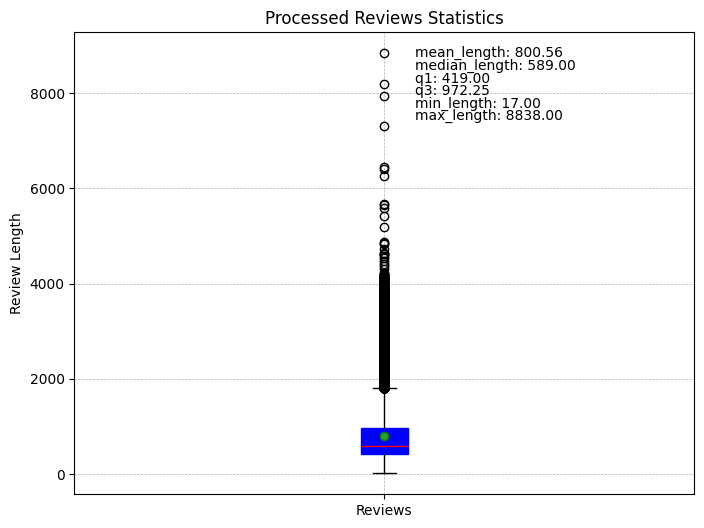

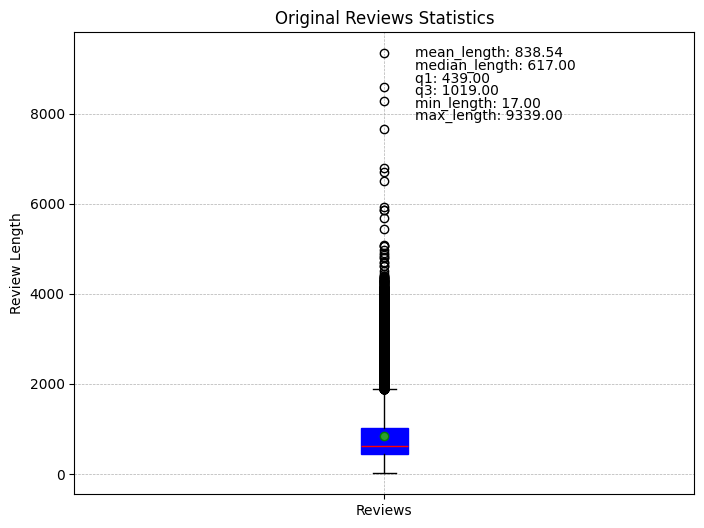

Defaulting to user installation because normal site-packages is not writeable


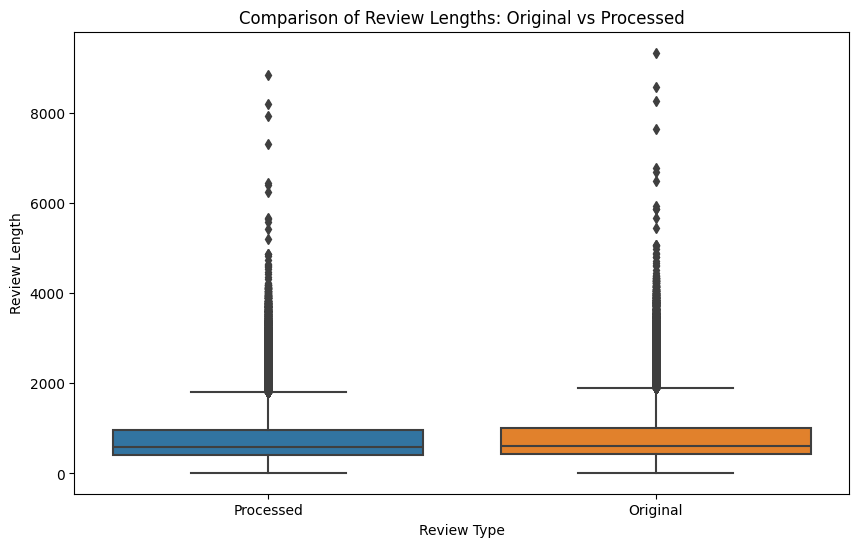

In [44]:
# Calculating the length of each cleaned review
data['review_length'] = data['processed_review'].apply(len)
export_curr_data_to_csv("4",data)
data_orig_copy['review_length'] = data_orig_copy['review'].apply(len)
# Displaying basic statistics
print("Statistics on the length of cleaned reviews:")
print(data['review_length'].describe())
print(data_orig_copy['review_length'].describe())


def calculate_review_statistics(review_lengths):
    """
    Calculate and return a dictionary of statistics for a given Series of review lengths.
    """
    return {
        'mean_length': review_lengths.mean(),
        'median_length': review_lengths.median(),
        'q1': review_lengths.quantile(0.25),
        'q3': review_lengths.quantile(0.75),
        'min_length': review_lengths.min(),
        'max_length': review_lengths.max(),
    }


import matplotlib.pyplot as plt


processed_review_stats = calculate_review_statistics(data['review_length'])

original_review_stats = calculate_review_statistics(data_orig_copy['review_length'])



def plot_review_statistics(review_lengths, stats, title):
    fig, ax = plt.subplots(figsize=(8, 6))
    bp = ax.boxplot(review_lengths, vert=True, patch_artist=True, showmeans=True)
    
    # Customizing the boxplot appearance
    bp['boxes'][0].set_color('blue')
    bp['medians'][0].set_color('red')
    bp['means'][0].set_marker('o')
    bp['means'][0].set_markeredgecolor('green')
    

    # Setting the x-axis limit to make room for annotations
    ax.set_xlim(0, 2)

    # Annotating statistics
    stat_y_base = max(review_lengths)  # Start annotations at the top
    y_offset = (max(review_lengths) - min(review_lengths)) * 0.03  # Space between annotations
    
    for i, (stat_name, stat_value) in enumerate(stats.items()):
        ax.text(1.1, stat_y_base - i * y_offset, f'{stat_name}: {stat_value:.2f}',
                horizontalalignment='left', verticalalignment='center')

    # Finalizing the plot
    ax.set_title(title)
    ax.set_ylabel('Review Length')
    ax.set_xticklabels(['Reviews'])  # Adjust tick label as needed
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)
    
    plt.show()
    return fig, ax

# Plot them separately
plot_review_statistics(data['review_length'], processed_review_stats, 'Processed Reviews Statistics')
plot_review_statistics(data_orig_copy['review_length'], original_review_stats, 'Original Reviews Statistics')


#graph to show both of them using seaborn
# Create a new DataFrame for plotting
!pip install seaborn
import seaborn as sns
length_comparison = pd.DataFrame({
    "Length": pd.concat([data['review_length'], data_orig_copy['review_length']]),
    "Type": ["Processed"] * len(data) + ["Original"] * len(data_orig_copy)
})




plt.figure(figsize=(10, 6))
sns.boxplot(x='Type', y='Length', data=length_comparison)
plt.title('Comparison of Review Lengths: Original vs Processed')
plt.ylabel('Review Length')
plt.xlabel('Review Type')
plt.show()

##### we can show the pos tags of the words in a graph or as stats
##### as a cake!

# Preparing the dataset for training
we can also use glove or previously used models as the first layer
1. Choose your vocabulary size K (should be between 1000 and 3000)
2. Find the top K frequent words in your database
3. Create word indexes like we did in class, for any word not in your top K  words replace with \<UNK\>. Remember to add an index for the \<PAD\> token.
4. Create a new dataset with indexes instead of words later to be used for training
5. Convert your labels to numeric representation (that your network can deal with).

Split the dataset to 80% traind and 20% test, remember to keep the balance between labels!
we need to make sure, we still have enough labels on both sides



In [52]:
from sklearn.model_selection import train_test_split


# Make sure, the preprocessed data is data['processed_review']
from collections import Counter

#vocabulary side
K = 3000

all_tokens = [token for sublist in data['processed_review'].str.split().tolist() for token in sublist]

token_counts = Counter(all_tokens)

vocab = {word for word, count in token_counts.most_common(K)}
print(vocab)
#if digitplaceholder in vocab:
   # print("Digit placeholder found in vocabulary!")

word_to_index = {word: idx + 3 for idx, word in enumerate(vocab)} 
word_to_index[digitplaceholder] = 2 # Start from 2 to reserve indices for special tokens
word_to_index['<UNK>'] = 1  # Unknown words
word_to_index['<PAD>'] = 0  # Padding

def text_to_sequence(text):
    return [word_to_index.get(word, word_to_index['<UNK>']) for word in text.split()]

data['indexed_text'] = data['processed_review'].apply(text_to_sequence)
print(data['indexed_text'].head())

#hello world <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>.... 500

def pad_sequences(sequences, maxlen):
    padded_sequences = []
    for seq in sequences:
        if len(seq) < maxlen:
            seq += [word_to_index['<PAD>']] * (maxlen - len(seq))
        else:
            seq = seq[:maxlen]
        padded_sequences.append(seq)
    return padded_sequences

maxlen = 500  # Choose a suitable maximum sequence length
data['padded_sequences'] = pad_sequences(data['indexed_text'].tolist(), maxlen)
print(data['padded_sequences'].head())
#export_curr_data_to_csv("5",data)
for i, seq in enumerate(data['padded_sequences'].head()):
    print(f"Sequence {i+1}: Length = {len(seq)}")
    #print(seq)
    print("\n")
#splitting test and train
#using sklearn model selection, we can split the data into test and train
#and give a paramater to maintain the same distribution of labels

#first numerate the sentiment col
# Convert sentiment labels from 'positive'/'negative' to 1/0
data['numeric_sentiment'] = data['sentiment'].map({'positive': 1, 'negative': 0})

features = data['padded_sequences'].tolist()
labels = data['numeric_sentiment'].tolist()

X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, stratify=labels, random_state=42)



{'context', 'nice', 'gun', 'bound', 'enjoyable', 'post', 'mistake', 'taste', 'outrageous', 'rogers', 'ha', 'butt', 'knight', 'enhance', 'manner', 'balance', 'grip', 'drive', 'guest', 'shift', 'treat', 'essential', 'location', 'scratch', 'rival', 'realise', 'direction', 'billy', 'devil', 'ago', 'justice', 'forgive', 'commercial', 'sea', 'ms', 'employ', 'decision', 'brazil', 'similarity', 'island', 'gritty', 'bell', 'power', 'baby', 'ignore', 'movement', 'distance', 'norman', 'angle', 'sheriff', 'award', 'played', 'bear', 'start', 'blow', 'dreadful', 'handful', 'station', 'report', 'wed', 'martin', 'playing', 'ape', 'whose', 'reputation', 'scary', 'ultimately', 'saturday', 'neither', 'user', 'chair', 'stephen', 'louis', 'glory', 'julie', 'porn', 'gruesome', 'quick', 'hammer', 'music', 'grace', 'favorite', 'japan', 'define', 'wound', 'roy', 'reason', 'bottle', 'raise', 'emily', 'connery', 'terribly', 'complete', 'dozen', 'birthday', 'cruise', 'particular', 'sarah', 'grab', 'stan', 'almost

# Training a feed forward neural network

For simplicity we would take only reviews with 500 words (after tokenization) or less.
For this part we would train a neural network that gets the full review as one input (like we had in our NER example in class) and outputs the label (positive or negative).
Remember that you need to PAD the words so all reviews will have the same length.

For this section please try at least 3 variants of different network and show if the results change, you can choose from the following:
1. Adding hidden layers to the network
2. Running with and without Dropout
3. Trying different optimizers

(Optional) Try to use the Glove embedding: Create an embedding layer in your PyTorch model using the loaded GloVe embeddings. You will initialize the weights of the embedding layer with the GloVe embeddings.

For each option:

* Plot the train and test error during training, does your network overfit?

* Plot the final results of the network, including accuracy and confusion matrix

In [55]:
!pip install torch
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import confusion_matrix, accuracy_score
import torch.nn.functional as F
import numpy as np

class SentimentClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, dropout=0.5, use_glove=False, glove_weights=None):
        super(SentimentClassifier, self).__init__()
        
        # Embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        
        # Initialize with GloVe embeddings if specified
        if use_glove:
            self.embedding.weight.data.copy_(torch.from_numpy(glove_weights))
            self.embedding.weight.requires_grad = False  # Make GloVe embeddings non-trainable
        
        # Linear layers
        self.fc1 = nn.Linear(embedding_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        
        # Dropout
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text):
        embedded = self.dropout(self.embedding(text))
        hidden = F.relu(self.fc1(embedded.mean(dim=1)))  # Mean pooling
        output = self.fc2(self.dropout(hidden))
        return output
train_data = TensorDataset(torch.from_numpy(np.array(X_train)), torch.from_numpy(np.array(y_train)))
test_data = TensorDataset(torch.from_numpy(np.array(X_test)), torch.from_numpy(np.array(y_test)))

batch_size = 64  # You can adjust this based on your GPU memory

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size)



Defaulting to user installation because normal site-packages is not writeable


In [68]:
vocab_size = K + 3  # Your top K words plus 3 for <PAD>, <UNK>, and digitplaceholder
embedding_dim = 100  # Example, adjust as needed
hidden_dim = 128  # Example, adjust as needed
output_dim = 1  # Binary classification

model = SentimentClassifier(vocab_size, embedding_dim, hidden_dim, output_dim, dropout=0.5)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters())

#need to add gpu check and use it 

#identifying overfitting.
train_losses, test_losses = [], []

num_epochs = 10  # Adjust based on your needs
print("started training")
for epoch in range(num_epochs):
    model.train()
    batch_losses = []
    for texts, labels in train_loader:
        texts, labels = texts.to(device).long(), labels.to(device).float()
        optimizer.zero_grad()
        predictions = model(texts).squeeze(1)
        loss = criterion(predictions, labels)
        loss.backward()
        optimizer.step()
        batch_losses.append(loss.item())
    train_losses.append(np.mean(batch_losses))
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}')
    # Add validation logic per epoch if desired
    # Calculate test loss for the current epoch
    print("started testing")
    model.eval()
    batch_test_losses = []
    with torch.no_grad():
        for texts, labels in test_loader:
           texts, labels = texts.to(device).long(), labels.to(device).float()
           predictions = model(texts).squeeze(1)
           loss = criterion(predictions, labels)
           batch_test_losses.append(loss.item())
    test_losses.append(np.mean(batch_test_losses))

    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_losses[-1]:.4f}, Test Loss: {test_losses[-1]:.4f}')





started training
Epoch 1/10, Loss: 0.644689679145813
started testing
Epoch 1/10, Train Loss: 0.6885, Test Loss: 0.6584
Epoch 2/10, Loss: 0.39164167642593384
started testing
Epoch 2/10, Train Loss: 0.5445, Test Loss: 0.4078
Epoch 3/10, Loss: 0.3655146062374115
started testing
Epoch 3/10, Train Loss: 0.3963, Test Loss: 0.3430
Epoch 4/10, Loss: 0.39460206031799316
started testing
Epoch 4/10, Train Loss: 0.3518, Test Loss: 0.3502
Epoch 5/10, Loss: 0.3245652914047241
started testing
Epoch 5/10, Train Loss: 0.3328, Test Loss: 0.3029
Epoch 6/10, Loss: 0.4415280818939209
started testing
Epoch 6/10, Train Loss: 0.3203, Test Loss: 0.3340
Epoch 7/10, Loss: 0.273966521024704
started testing
Epoch 7/10, Train Loss: 0.3109, Test Loss: 0.3009
Epoch 8/10, Loss: 0.33911824226379395
started testing
Epoch 8/10, Train Loss: 0.3058, Test Loss: 0.2948
Epoch 9/10, Loss: 0.2749214172363281
started testing
Epoch 9/10, Train Loss: 0.3011, Test Loss: 0.2858
Epoch 10/10, Loss: 0.2682975232601166
started testing
E

Train Losses: [0.6885444466590881, 0.54449798579216, 0.39627189946174624, 0.35179025301933287, 0.3327609683275223, 0.3202952466249466, 0.3109133381605148, 0.3058071905374527, 0.30108355717658997, 0.2948835326075554]
Test Losses: [0.6583961658417039, 0.4078467182672707, 0.343029519365092, 0.35018543918041667, 0.3029234061954887, 0.3339722823754997, 0.3009207124353214, 0.29480046589093606, 0.2857584147506459, 0.2856491632332468]
Number of training loss entries: 10
Number of testing loss entries: 10


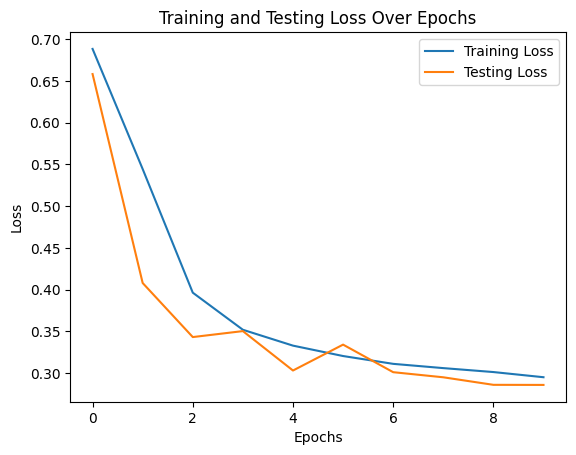

In [70]:
print("Train Losses:", train_losses)
print("Test Losses:", test_losses)
print(f"Number of training loss entries: {len(train_losses)}")
print(f"Number of testing loss entries: {len(test_losses)}")

plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Testing Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Testing Loss Over Epochs')
plt.legend()
plt.show()

Accuracy: 0.8824
[[4409  591]
 [ 585 4415]]
[['4409' '591']
 ['585' '4415']]


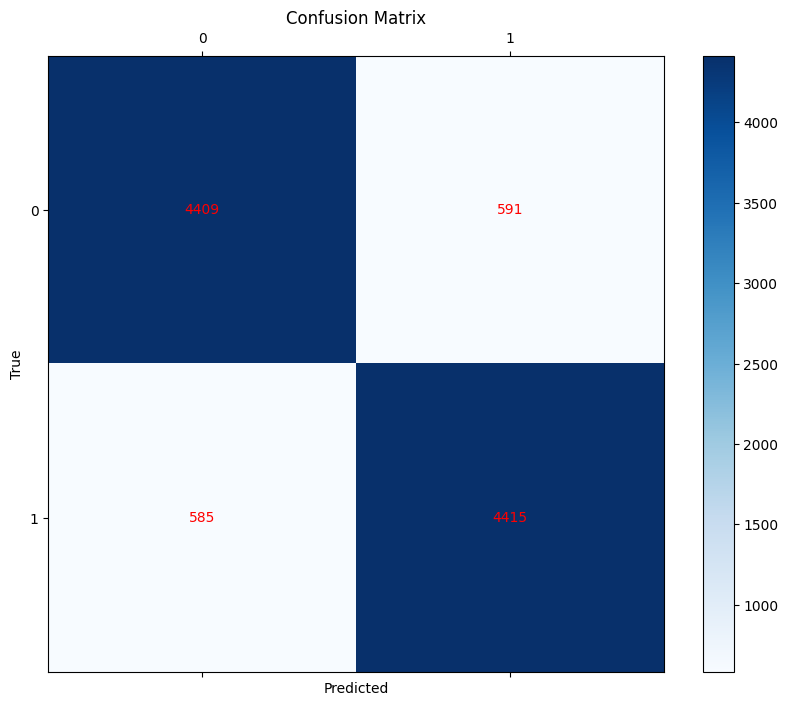

In [98]:
# Set the model to evaluation mode
model.eval()

# Lists to store predictions and true labels
all_predictions = []
all_labels = []

# Disable gradient computation
with torch.no_grad():
    for texts, labels in test_loader:
        # Move data to the appropriate device (GPU if available)
        texts = texts.to(device).long()
        labels = labels.to(device).float()

        # Forward pass to get outputs
        predictions = model(texts).squeeze(1)

        # Convert predictions to binary values (0 or 1)
        predicted_labels = torch.round(torch.sigmoid(predictions))

        # Collect all predictions and true labels
        all_predictions.extend(predicted_labels.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Now, you can calculate metrics such as accuracy
accuracy = accuracy_score(all_labels, all_predictions)
print(f'Accuracy: {accuracy:.4f}')



# And generate a confusion matrix
cm = confusion_matrix(all_labels, all_predictions)
print(cm)

annot = np.array([['{:.0f}'.format(value) for value in row] for row in cm])
print(annot)
#currntly not working propley
# trying to update matplotlib to fix it
#sns wasnt working for heatmap
# Plotting directly with Matplotlib
fig, ax = plt.subplots(figsize=(10, 8))
cax = ax.matshow(cm, cmap='Blues')

# Adding annotations manually
for (i, j), val in np.ndenumerate(cm):
    ax.text(j, i, annot[i, j], ha='center', va='center', color='red')

plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
fig.colorbar(cax)
plt.show()


# Training a BiDir LSTM neural network

Now do the same as the prvious section with a bi-directional LSTM.

Remember that the output of the LSTM should be connected to a small feed forward network to perform the actual classification.

Here again you can play with number of layers and the LSTM or the small network of the output. Show only the best result you got.

* Plot the train and test error during training, does your network overfit?

* Plot the final results of the network, including accuracy and confusion matrix

Are the results better than the previous section?




Finally show 3 reviews from the test data with correct labales and 3 without, why do you think the network did not success on these examples?